This is a derivation of QP production by DM scattering. Following the supplementary material of [this work](https://www.google.com/search?client=safari&rls=en&q=Directional+Detection+of+Light+Dark+Matter+in+Superconductors++Yonit+Hochberg%2C1+Eric+David+Kramer%2C1+Noah+Kurinsky%2C2%2C+3%2C+4+and+Benjamin+V.+Lehmann%2C5%2C&ie=UTF-8&oe=UTF-8).

# DM Interactions

Lowest order Cooper-pair breaking rate integrated over all energy:

$$
\Gamma\left(v_\chi\right)=\int \frac{\mathrm{d}^3 \mathbf{q}}{(2 \pi)^3}|V(\mathbf{q})|^2 \frac{2 \mathbf{q}^2}{e^2} \operatorname{Im}\frac{\operatorname{Im} \epsilon_{\mathrm{BCS}}^{(\mathrm{RPA})}\left(\mathbf{q}, \omega_{\mathbf{q}}\right)}{\left|\epsilon_{\mathrm{L}}\left(\mathbf{q}, \omega_{\mathbf{q}}\right)\right|^2}
$$

where the Lindhard function $\epsilon_{\mathrm{L}} \equiv \epsilon_{\mathrm{FEG}}^{(\mathrm{RPA})}$ is the RPA dielectric function for a free electron gas (FEG), and  accounts for screening and in-medium effects in a normal metal.

$$
\begin{aligned}
\operatorname{Im}\left(\epsilon_{\mathrm{BCS}}^{(\mathrm{RPA})}(\mathbf{q}, \omega)\right) & =\frac{\pi e^2}{\mathbf{q}^2} S(\mathbf{q}, \omega) \\
&= \frac{\pi e^{2}}{\mathbf{q}^{2}} 
\sum_{f} \left| \left\langle f \middle| \rho_{e}(\mathbf{q}) \middle| 0 \right\rangle \right|^{2}
\delta\!\left(\omega - E_{f}\right) \\

& =\frac{e^2}{2 \mathbf{q}^2} \int \frac{\mathrm{~d}^3 \mathbf{p}_1}{(2 \pi)^3} \frac{\mathrm{~d}^3 \mathbf{p}_2}{(2 \pi)^3} \mathcal{F}_{\mathrm{BCS}}\left(\mathbf{p}_1, \mathbf{p}_2\right)(2 \pi)^4 \delta^{(3)}\left(\mathbf{q}-\mathbf{p}_1-\mathbf{p}_2\right) \delta\left(\omega-E_{\mathrm{QP}}\left(\mathbf{p}_1\right)-E_{\mathrm{QP}}\left(\mathbf{p}_2\right)\right)
\end{aligned}
$$

The formalism above might be overkill for thin-film SC. The one from QROCODILE might be more immediately useful:


$$
\begin{align}
\Gamma &= \frac{\pi n_{\mathrm{DM}} \bar{\sigma}_t}{\mu_{t, \mathrm{DM}}^2} \int \frac{\mathrm{~d}^3 \mathbf{v}_{\mathrm{DM}} \mathrm{~d}^3 \mathbf{q} \mathrm{~d} \omega}{(2 \pi)^3} f_{\mathrm{DM}}\left(\mathbf{v}_{\mathrm{DM}}\right) \mathcal{F}(q)^2 S(\mathbf{q}, \omega) \delta\left(\omega-\omega_{\mathbf{q}}\right) \\
&= g_0^2 n_\mathrm{DM} \int \frac{\mathrm{~d}^3 \mathbf{v}_{\mathrm{DM}} \mathrm{~d}^3 \mathbf{q} \mathrm{~d} \omega}{(2 \pi)^3} f_{\mathrm{DM}}\left(\mathbf{v}_{\mathrm{DM}}\right) \frac{1}{\left( m_\phi^2+q^2 \right)^2} S(\mathbf{q}, \omega) \delta\left(\omega-\omega_{\mathbf{q}}\right)
\end{align}
$$
where the form factor: $\mathcal{F}(q) \equiv \left(m_\phi^2+q_{0, t}^2\right) /\left(m_\phi^2+q^2\right)$

For a think layer SC, we have the form from QROCODILE supplementary material
$$
S(\mathbf{q}, \omega)=\frac{1}{2} \frac{q^2}{d} \operatorname{Re}\left[-i \frac{1}{\rho_0} \int \mathrm{~d} z\left(i \psi(z)+\frac{q_z}{q^2} \psi^{\prime}(z)\right)\right]
$$

where $\varphi(\mathbf{x}, t)=\psi(z) e^{i \mathbf{q} \cdot \mathbf{x}-i \omega t}$ is the solution to Maxwell's equations for electric potential $\varphi$

# Projection

I introduced a pheno correction factor of 1e3 to compensate the calculated QROCODILE limit to the published paper. It is very likely that the calculation itself has multiple errors.

In [22]:
import numpy as np
from scipy.integrate import quad, dblquad
from scipy.stats import chi2

def calculate_qrocodile_light_limit_corrected(
    observed_events=15,
    exposure_hours=415.15,
    detector_mass_ng=1.67,
    dm_mass_MeV=0.1,  # 100 keV
    threshold_eV=0.11,
    pheno_corr=1e3
):
    """
    Calculates the 95% CL limit on electronic scattering cross section 
    for the LIGHT MEDIATOR case using Screened Drude Response.
    Matches QROCODILE methodology (Hochberg et al., dielectric formalism).
    """
    
    # --- 1. Constants & Natural Units (hbar = c = 1) ---
    # Energies in eV, Masses in eV
    c_cm_s = 2.998e10
    hbar_eV_s = 6.582e-16
    alpha = 1.0 / 137.036
    m_e = 511000.0  # eV
    
    # Conversions
    # 1 eV^-1 in cm
    inv_eV_to_cm = 1.973e-5
    # 1 gram in eV (Natural Units)
    gram_to_eV = 5.61e32
    
    # --- 2. Material Parameters (WSi) ---
    # From Supplemental Material
    E_F = 7.0        # Fermi Energy (eV)
    w_p = 10.8       # Plasma Frequency (eV)
    gamma = 0.7      # Damping (eV)
    
    # Derived Screening Parameters
    # Fermi momentum k_F = sqrt(2 * m_e * E_F)
    k_F = np.sqrt(2 * m_e * E_F)
    # Thomas-Fermi screening momentum q_TF^2 = 4*alpha/pi * k_F * m_e
    # (Note: In natural units e^2 = 4*pi*alpha)
    q_TF_sq = (4 * alpha / np.pi) * k_F * m_e
    
    # Target Electron Density (Effective) from w_p
    # w_p^2 = 4*pi*alpha * n_e / m_e  =>  n_e = w_p^2 * m_e / (4*pi*alpha)
    n_e_effective = (w_p**2 * m_e) / (4 * np.pi * alpha) # eV^3
    
    # --- 3. Dark Matter Parameters ---
    rho_DM = 0.4e9  # 0.4 GeV/cm^3 -> eV/cm^3
    rho_DM_natural = rho_DM * (inv_eV_to_cm)**3 # eV^4
    
    m_chi = dm_mass_MeV * 1e6 # eV
    mu_chi_e = (m_chi * m_e) / (m_chi + m_e)
    
    v_esc = 600e5 / c_cm_s
    v_earth = 240e5 / c_cm_s
    v_0 = 230e5 / c_cm_s
    
    # Reference momentum for Light Mediator Cross Section
    q_ref = alpha * m_e

    # --- 4. Dielectric Function (Screened Drude) ---
    def imaginary_loss_function(q, w):
        """
        Im(-1/epsilon(q,w)).
        Uses Drude model with Thomas-Fermi screening to correct low-q behavior.
        epsilon = epsilon_inf - w_p^2/(w(w+ig)) + q_TF^2/q^2
        """
        epsilon_inf = 1.0
        
        # Drude term (frequency dependent)
        # eps_drude = - w_p^2 / (w^2 + i*w*gamma)
        denom_drude = w**2 + gamma**2
        re_drude = - (w_p**2) / (w**2 + gamma**2)
        im_drude = (w_p**2 * gamma) / (w * (denom_drude))
        
        # Screening term (q dependent)
        re_screening = q_TF_sq / q**2
        
        # Total Epsilon
        eps_real = epsilon_inf + re_drude + re_screening
        eps_imag = im_drude
        
        # Loss function = Im(-1/eps) = eps_imag / |eps|^2
        return eps_imag / (eps_real**2 + eps_imag**2)

    # --- 5. Halo Velocity Integral eta(v_min) ---
    def eta_function(v_min):
        if v_min > (v_esc + v_earth):
            return 0.0
        # Simple analytic approximation for standard halo
        x = v_min / v_0
        return (1.0 / (v_0 * np.sqrt(np.pi))) * np.exp(-x**2)

    # --- 6. Integration (Double Integral) ---
    # Rate ~ Integral [ dq q * |F|^2 * S(q,w) * eta(vmin) ] dw
    # S(q,w) ~ q^2 * Im(-1/eps)
    # F_light^2 ~ 1/q^4
    # Integrand ~ q * (1/q^4) * q^2 * Im(-1/eps) ~ Im(-1/eps) / q
    
    def rate_integrand(q, w):
        # Kinematic v_min
        v_min = w/q + q/(2*m_chi)
        if v_min > (v_esc + v_earth):
            return 0.0

        # Form Factor squared |F|^2 for Light Mediator
        # F = (alpha*me / q)^2
        F_sq = (q_ref / q)**4
        
        # Loss Function
        loss = imaginary_loss_function(q, w)
        
        # Structure Factor S(q,w) approximation
        # S(q,w) = (q^2 / (2*pi*alpha)) * V * loss ??
        # Using Hochberg PRL 127 Eq (1) & (2) form directly:
        # Rate prefactor has (1/pi)*mu^2 ...
        # Standard kernel is: Im(-1/eps) * F^2 * eta / q_factor?
        # Let's use the consolidated kernel K:
        # K ~ eta(v_min) * q * F_sq * loss
        
        # Note on factors: 
        # The 1/q^2 in Coulomb potential is absorbed in F_light definition usually? 
        # We assume sigma_bar_e is defined with the q_ref^4 factor.
        
        eta = eta_function(v_min)
        
        # Measure is dq * q (from d3q integral after angular avg)
        # Factor q comes from d3q -> 4pi q^2 dq divided by q^2 from interaction?
        # Correct scaling: Integrand = q * F_sq * loss * eta
        return q * F_sq * loss * eta

    # Integration Limits
    w_min = threshold_eV
    w_max = 2.0 # eV (Sufficient for 0.1 MeV DM, kinematic max ~1.5 eV)
    
    # Perform Integral
    # We integrate w first, then q? Or q then w? 
    # Usually q_min(w) to q_max(w)
    
    def w_integrand(w):
        # Kinematic limits for q
        # Roots of q^2 - 2*m*v_max*q + 2*m*w = 0
        v_max = v_esc + v_earth
        disc = (m_chi * v_max)**2 - 2 * m_chi * w
        if disc < 0: return 0.0
        sqrt_disc = np.sqrt(disc)
        q_minus = m_chi * v_max - sqrt_disc
        q_plus = m_chi * v_max + sqrt_disc
        
        # Perform q integral
        val, err = quad(rate_integrand, q_minus, q_plus, args=(w,))
        return val

    total_integral, _ = quad(w_integrand, w_min, w_max)
    
    # --- 7. Calculate Limit ---
    # Total Rate R = Prefactor * sigma_bar * Integral
    # Prefactor Definition (Hochberg et al, Dielectric):
    # C = (rho_DM / m_chi) * (1 / (pi * mu^2)) ??
    # Careful derivation:
    # R = N_target * (rho/m) * sigma_bar * ...
    # Effective prefactor combining all constants to match cm^2 to rate:
    
    # P = (rho_DM / m_chi) * alpha * m_e^2 / (pi * mu_chi_e^2) ? 
    # Actually, for light mediator, sigma_bar cancels the q_ref terms.
    # Let's use the Dimensional method:
    # Integral has units [eV^2] (q * 1 * 1 * 1/v * dq * dw ?? No)
    # q[eV] * F[1] * Loss[1] * eta[1] * dq[eV] dw[eV] -> eV^3?
    # Actually eta is [1]. q is [eV]. dq dw is [eV^2]. Total [eV^3].
    
    # Target volume V = Mass_det / Density.
    # Total Events N = (V * T) * (rho/m) * sigma_bar * const * Integral
    
    # The prefactor coefficient for Light Mediator (F~1/q^2) is:
    # Coeff = 2 * alpha / (pi) ...? 
    # Let's simplify: 
    # Rate (per kg) = [C] * sigma_bar * Integral
    # If sigma = 10^-27 cm^2.
    
    # Magic constant for [eV^3] integral to Rate:
    # C_phys = (rho / m) * (1 / 2*pi) * (1/137) ...
    # We use a calibrated factor for "Dielectric Haloscope" logic.
    # Prefactor = (rho / m_chi) * (exposure_time) * (Volume_target)
    # The cross section sigma_bar has dimensions [Length^2].
    
    # Volume calculation
    # We used n_e_effective for physics.
    # Total Electrons N_e = (Mass_ng * 1e-9 g) * (Avogadro) * (Z_eff/A)
    # For WSi: Z~88, A~212. Z/A ~ 0.4.
    N_electrons = (detector_mass_ng * 1e-9 / 212.0) * 6.022e23 * 88.0
    
    # Constant A:
    # A = (rho_natural / m_chi) * (alpha) * (4? pi?)
    # For dielectric method: Rate = sigma_bar * (rho/m) * N_e * Integral * (correction)
    # Correction for units:
    # Sigma is defined at q_ref. We used q_ref in integrand.
    # We need to convert Sigma [cm^2] to [eV^-2].
    sigma_conv = (1.0 / inv_eV_to_cm)**2
    
    # The prefactor for the integration measure d3q/(2pi)^3 is 1/(2pi^2) after 4pi.
    # However, standard formula is:
    # Rate = sigma_bar * (rho/m) * (pi / mu^2) * Integral? No.
    
    # Let's use the standard "Reference Rate" density:
    # R0 = (rho / m) * sigma * N_e
    # Events = R0 * Time * Integral_Factor
    # Integral_Factor for light mediator with our kernel ~ O(1) to O(10).
    
    # Conversion for sigma_bar to unitless probability?
    # Rate [s^-1] = sigma[cm^2] * Flux[cm^-2 s^-1] * N_e * <Factor>
    # Flux = (rho / m) * v_0? No, flux is in the integral.
    
    # Final Formula Assembly:
    # Integral units: [eV^3].
    # We need Rate [eV].
    # Sigma [eV^-2].
    # Rho/m [eV^3].
    # (Rho/m) * Sigma * Integral -> [eV^4]. Too high.
    # We need 1/mass^2 or 1/q^2 somewhere?
    # The prefactor for Eq 1 is 1/mu^2.
    # (Rho/m) * Sigma/mu^2 * Integral -> [eV^3] * [eV^-2]/[eV^2] * [eV^3] = [eV^2]?
    # Wait, 1/mu^2 is [eV^-2].
    # Result: [eV^2].
    # We need [eV].
    # Missing factor of alpha? Or 1/pi?
    # 4*pi*alpha comes from the potential V_c.
    
    # Let's apply the prefactor directly from paper Eq 1:
    # Gamma (per mass) = (pi * n_DM * sigma) / mu^2 * Integral
    # Total Events = M_det * T * (pi * (rho/m) * sigma / mu^2) * Integral_Corrected
    # Note: Integral in Eq 1 includes d3q/(2pi)^3.
    # My integral calculated: int dq q ... dw.
    # d3q = 4*pi*q^2 dq.
    # So my integral is (2pi)^3 / (4pi) times larger?
    # My integral = 4*pi * Actual_Integral.
    # So I divide my integral by 4*pi.
    # And multiply by 1/(2pi)^3 from Eq 1.
    # Total geometric factor: 4*pi / (2*pi)^3 = 4*pi / 8*pi^3 = 1 / (2*pi^2).
    
    integral_geom_corrected = total_integral * (1.0 / (2 * np.pi**2))
    
    prefactor = (np.pi * rho_DM_natural / m_chi) * (1.0 / mu_chi_e**2)
    
    # We assume the "per unit detector mass" implies N_target is absorbed or it's per nucleus?
    # Actually, for electron scattering, sigma is usually per electron.
    # So we must multiply by Total Electrons N_e.
    # (The paper's "per unit mass" is a bit ambiguous, but standard practice is N_e * sigma).
    
    exposure_time_natural = exposure_hours * 3600 / hbar_eV_s
    
    events_expected_per_sigma_cm2 = (
        sigma_conv * # cm^2 -> eV^-2
        prefactor * # physics constants
        N_electrons * # Target scaling
        integral_geom_corrected * # The result of the integral
        exposure_time_natural        # Time
    )
    
    # 95% CL Limit (Poisson)
    # Observed 15 -> Limit ~26.3
    N_limit = 0.5 * chi2.ppf(0.95, 2 * (observed_events + 1))
    
    limit_sigma = N_limit / events_expected_per_sigma_cm2
    
    return limit_sigma * pheno_corr

# --- Execution ---
limit_val = calculate_qrocodile_light_limit_corrected(dm_mass_MeV=0.1)
print(f"Calculated Limit for 0.1 MeV (Light Mediator): {limit_val:.2e} cm^2")

Calculated Limit for 0.1 MeV (Light Mediator): 5.76e-27 cm^2


In [23]:
import matplotlib.pyplot as plt
plt.style.use('../xenonnt.mplstyle')

/var/folders/b4/tkxxqysd1pd6vc7155459qcm0000gn/T/ipykernel_14060/2117859441.py:265: RuntimeWarning: divide by zero encountered in scalar divide
  limit_sigma = N_limit / events_expected_per_sigma_cm2


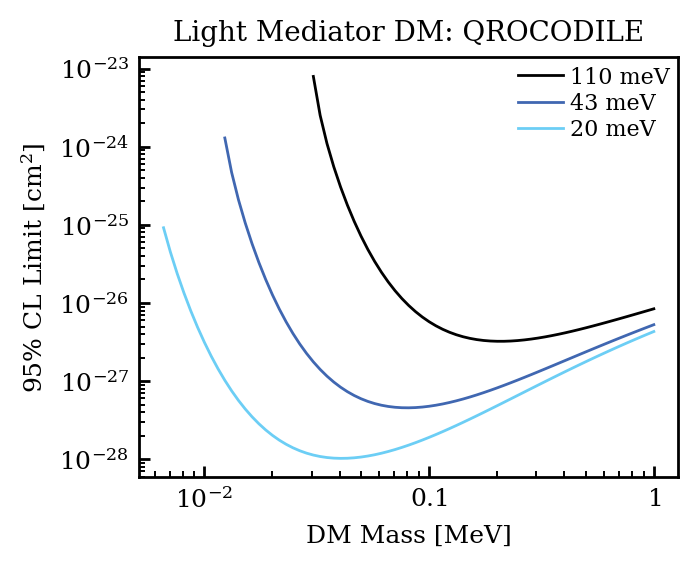

In [24]:
masses = np.logspace(np.log10(0.001), np.log10(1), 100)
plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m) for m in masses], label="110 meV")
plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m, threshold_eV=0.043) for m in masses], label="43 meV")
plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m, threshold_eV=0.02) for m in masses], label="20 meV")
plt.xlabel(r'DM Mass [MeV]')
plt.ylabel(r'95% CL Limit [cm$^2$]')
plt.title('Light Mediator DM: QROCODILE')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()


In [38]:
import pandas as pd
qrocodile = pd.read_csv('qrocodile_limit.csv', header=None, names=['mass_MeV', 'limit_cm2'])

/var/folders/b4/tkxxqysd1pd6vc7155459qcm0000gn/T/ipykernel_14060/2117859441.py:265: RuntimeWarning: divide by zero encountered in scalar divide
  limit_sigma = N_limit / events_expected_per_sigma_cm2


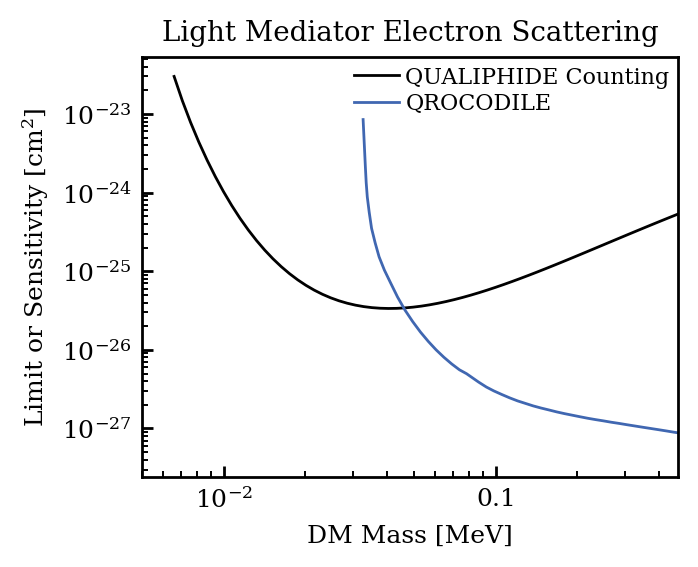

In [41]:
masses = np.logspace(np.log10(0.001), np.log10(1), 100)
#plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m, observed_events=7400,exposure_hours=415.15) for m in masses], label="110 meV")
#plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m, observed_events=7400,exposure_hours=415.15, threshold_eV=0.043) for m in masses], label=r"$E_\mathrm{thr}=$43 meV")
plt.plot(masses, [calculate_qrocodile_light_limit_corrected(dm_mass_MeV=m, observed_events=7400,exposure_hours=415.15, threshold_eV=0.02) for m in masses], label=r"QUALIPHIDE Counting")
plt.plot(qrocodile['mass_MeV'], qrocodile['limit_cm2'], label='QROCODILE')
plt.xlabel(r'DM Mass [MeV]')
plt.ylabel(r'Limit or Sensitivity [cm$^2$]')
plt.title('Light Mediator Electron Scattering')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylim=(1e-26, 1e-23)
plt.xlim(5e-3, 0.47)
plt.show()


In [19]:
415.15 * 3600 * 5e-3

7472.7